In [1]:
import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

from compute_correlations import compute_pearson_correlation, compute_kendall_correlation
from graphs import build_full_graph, build_threshold_graph, find_max_clique, find_max_independent_set

In [2]:
df = pd.DataFrame({
    'moscow': [28.0, 23.0, 28.0, 22.0, 22.0, 16.0, 25.0, 24.0, 20.0, 18.0],
    'spb': [10.0, 21.0, 21.0, 17.0, 21.0, 11.0, 22.0, 10.0, 13.0, 21.0],
    'kazan': [21.0, 23.0, 23.0, 20.0, 23.0, 26.0, 32.0, 22.0, 22.0, 24.0],
    'ufa': [16.0, 11.0, 19.0, 14.0, 18.0, 19.0, 17.0, 11.0, 17.0, 11.0],
    'nizhny': [20.0, 20.0, 15.0, 19.0, 16.0, 22.0, 15.0, 17.0, 18.0, 18.0],
})

In [3]:
df.corr(method='pearson')

,moscow,spb,kazan,ufa,nizhny
moscow,1.000000,0.092547,-0.089041,0.087538,-0.478493
spb,0.092547,1.000000,0.370167,-0.026827,-0.542535
kazan,-0.089041,0.370167,1.000000,0.271384,-0.299536
ufa,0.087538,-0.026827,0.271384,1.000000,-0.160301
nizhny,-0.478493,-0.542535,-0.299536,-0.160301,1.000000


In [4]:
vertices = ['moscow', 'spb', 'kazan', 'ufa', 'nizhny']
edge_weights = compute_pearson_correlation(df)

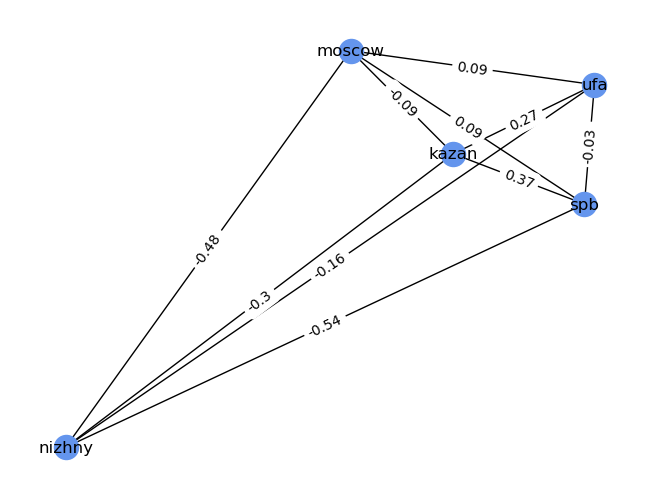

In [5]:
g_full = build_full_graph(vertices, edge_weights)
pos = nx.spring_layout(g_full)
nx.draw(g_full, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g_full, 'weight').items()}
nx.draw_networkx_edge_labels(g_full, pos, edge_labels);

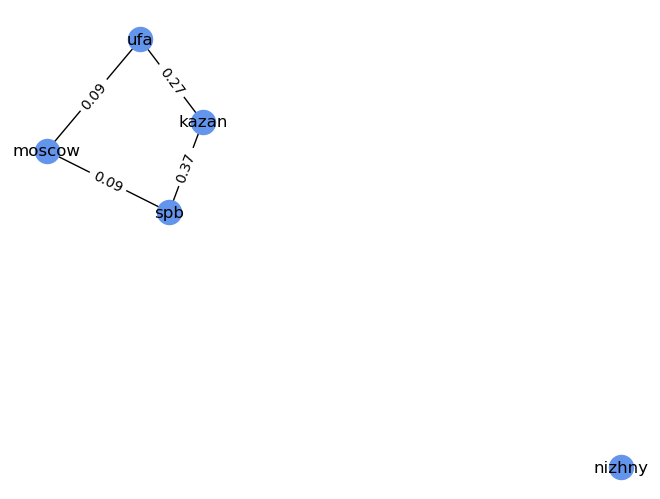

In [6]:
g = build_threshold_graph(vertices, edge_weights, threshold=0.0)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
nx.draw_networkx_edge_labels(g, pos, edge_labels);

In [7]:
find_max_clique(g)

[['spb', 'kazan']]

In [8]:
find_max_independent_set(g)

['nizhny', 'moscow', 'kazan']